# Introduction to Adversarial Attacks

# 1. Loading a CNN
To save time, we will use a pretrained CNN (on the CIFAR-10 dataset) in order to test various adversarial methods. It has a straight-forward architecture, which is shown below. To save having to store the model architecture as a file, only the weights can be stored, and the model architecture can be replicated as follows.


In [4]:
import torch
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU, Dropout #All of the necessary layers for this model

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.pooling = MaxPool2d(2,2)
        self.dropout = Dropout(p=0.3)
        self.conv2 = Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.relu = ReLU()
        self.flatten = Flatten()
        self.linear1 = Linear(2048, 128)
        self.linear2 = Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) #Convolution layer
        x = self.pooling(x) #Max Pooling Layer
        x = self.dropout(x) #Dropout Layer
        x = self.conv2(x) #Second Convolution Layer
        x = self.pooling(x) #Second Pooling Layer
        x = self.flatten(x) #Flatten Layer
        x = self.relu(self.linear1(x)) #Regular Layer
        x = self.dropout(x) #Second Dropout Layer
        x = self.linear2(x) #Output Layer
        return x

In [6]:
model = CNN()
model.load_state_dict(torch.load('CNN_weights.pth'))
model.eval() #Puts the model on 'eval mode', stopping Dropout operations

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

# 2. Loading and Processing Images

Images must be converted into pytorch tensors of a specific size for prediction.

Write a function that converts 'frog.jpg' into a transformed pytorch tensor and resizes it to (32,32)

Hint: use Compose([Transform1(), Transform2()])

In [79]:
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image

def process_image(path):
    img = Image.open(path)
    ###TODO
    #Write a PyTorch image composition to resize and convert to a tensor
    transform = Compose([Resize((32,32)), ToTensor()])
    ###
    processedImg = transform(img)
    processedImg = processedImg.unsqueeze(0)
    return processedImg

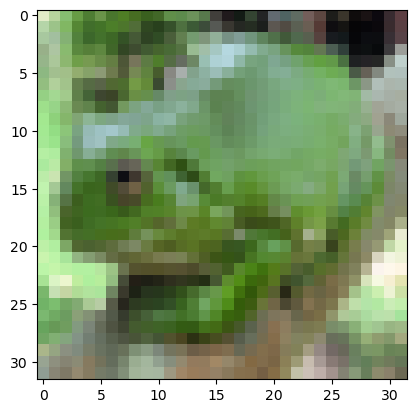

In [81]:
import matplotlib.pyplot as plt

def show_image(img):
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0).detach().numpy()) #Reorder columns as PIL and Torch order image data differently

show_image(process_image('frog.jpg'))

## 2a. Making Predictions
Using the function you created above, predict what the model classifies the frog to be.

If prediction leads to an error, the CNN was likely constructed incorrectly.


In [14]:
def prediction(img):
    classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    with torch.no_grad(): #Stops calculating gradients
        prediction = model(img)
        _, pred_class = torch.max(prediction, 1)
    probs = prediction.softmax(dim=-1) #Softmax function used to calculate probabilities
    return pred_class, classes[pred_class], probs[0][pred_class]

###TODO
#Use the above functions to predict 'frog.jpg'
print(prediction(process_image('frog.jpg')))

(tensor([6]), 'frog', tensor([0.2549]))


# 3. Making an adversarial image using FGSM
$ x' = x + \epsilon \cdot sign(\nabla loss_{F,t}(x))
$

Using the above formula, complete the code for FGSM (Fast Gradient Sign Method). Work out the loss produced by the generated output with regard to the correct output (using loss_fn), and then calculate the gradient of this loss, relative to the input data. Then find the signs of the gradient, and adjust x accordingly.

The loss function, CrossEntropyLoss, has also been included.

The below example demonstrates how to find the gradient of the loss function relative to the input image.

In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
x = process_image('frog.jpg')
x.requires_grad = True #Turn on gradient calculation
output = model(x)
loss = loss_fn(output, torch.tensor([6])) #Find loss 
loss.backward() #Calculating gradient
loss_gradient = x.grad.data
x = x.detach() 

In [34]:
import numpy as np

def FGSM_generator(path, y, epsilon=3/1000):
    x = process_image(path)
    x.requires_grad = True
    output = model(x)
    loss = loss_fn(output, y)
    model.zero_grad()
    loss.backward()
    loss_gradient = x.grad.data
    x = x.detach()
    x_dash = x + (epsilon * np.sign(loss_gradient))
    x_dash = torch.clamp(x_dash, 0, 1)
    return x_dash
        
path = 'frog.jpg'
x_adv_FGSM = FGSM_generator(path, prediction(process_image(path))[0])
pred = prediction(x_adv_FGSM)
print(f"Prediction: {pred[1]} with probability {pred[2][0]:.2f}")

Prediction: deer with probability 0.24


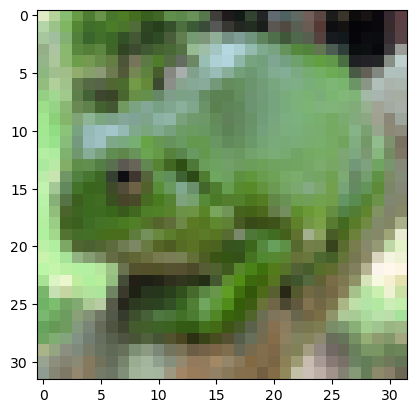

In [36]:
show_image(x_adv_FGSM)

# 4. Making an adversarial image using IGSM 
$ x'_i = x'_{i-1} + clip_\epsilon(\alpha \cdot sign(\nabla loss_{F,t}(x'_{i-1})))
$

Using the above formula, complete the code for IGSM (Iterative Gradient Sign Method)

Before, complete the helper function for clipping. All this operation has to do is force x to be between x - ε and x + ε, and between 0 and 1. The clamp function can be used for this.

In [40]:
from torch import clamp

def clip(x, epsilon):
    ### TODO
    #Clip x epsilon distance away
    #Clip x between 0 and 1
    x = torch.clamp(x, x - epsilon, x + epsilon)
    x = torch.clamp(x, 0, 1)
    return x

In [58]:
def IGSM_generator(path, y, epsilon=1/1000, alpha=0.0005, num_iters=6):
    
    x = process_image(path)
    x.requires_grad = True
    for i in range(num_iters):
        x.requires_grad = True
        output = model(x)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        loss_gradient = x.grad.data
        x = x.detach()
        x = x + alpha * torch.sign(loss_gradient)
        x = clip(x, epsilon)
        
    return x
    
path = 'frog.jpg'
x_adv_IGSM = IGSM_generator(path, prediction(process_image(path))[0])
pred = prediction(x_adv_IGSM)
print(f"Prediction: {pred[1]} with probability {pred[2][0]:.2f}")

Prediction: deer with probability 0.24


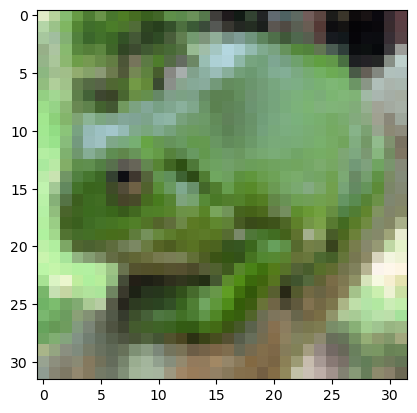

In [60]:
show_image(x_adv_IGSM)

# 5. Making an adversarial image using PGD

PGD is almost identical to IGSM, with the only difference being 'random' intialization rather than zero.

A helper function has been included to help do this. The 'clip' function included above is also necessary.

In [62]:
def add_noise(img, stdev=0.001, mean=0):
    noise = torch.randn_like(img) * stdev + mean
    return img + noise

def PGD_generator(path, y, epsilon=1/1000, alpha=0.0005, num_iters=6):

    model.eval()
    x = process_image(path)
    x = add_noise(x)
    x = torch.clamp(x, -1, 1)

    for i in range(num_iters):
        x.requires_grad = True
        output = model(x)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        loss_gradient = x.grad.data
        x = x.detach()
        x = x + alpha * torch.sign(loss_gradient)
        x = clip(x, epsilon)
        
    return x

path = 'frog.jpg'
x_adv_PGD = PGD_generator(path, prediction(process_image(path))[0])
pred = prediction(x_adv_PGD)
print(f"Prediction: {pred[1]} with probability {pred[2][0]:.2f}")

Prediction: deer with probability 0.24


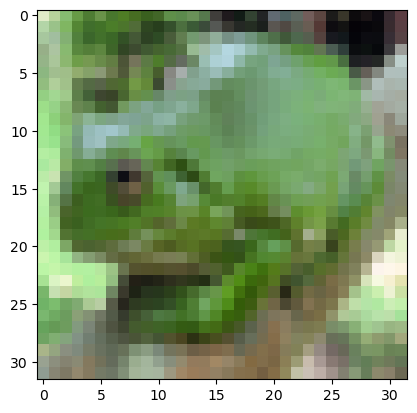

In [64]:
show_image(x_adv_PGD)

# 6. Evaluating the distance


Now, we will evaluate the distance between the original image and the adversarial images.

Using the below formula:

$
\|v\|_p = \left( \sum_{i=1}^{n} |v_i|^p \right)^{\frac{1}{p}}.
$

Where v is the absolute difference between the input image and the adversarially perturbed image, complete the following function. This is equivalent to calculating the L_p norm.

Due to the addition of random noise, the distance for PGD will fluctuate around that of IGSM if they have the same parameters.

While numerical stability might render it impossible, the L_p norm should converge to the L_inf norm as p goes to infinity.

In [68]:
def distance(x1, x2, p):
    x = (torch.abs(x1 - x2)) ** p
    x = torch.sum(x)
    return x ** (1/p)

In [99]:
x = process_image('frog.jpg')
print(f"Distance for FGSM: {distance(x, x_adv_FGSM, 2):.2f}")
print(f"Distance for IGSM: {distance(x, x_adv_IGSM, 2):.2f}")
print(f"Distance for PGD: {distance(x, x_adv_PGD, 2):.2f}")

Distance for FGSM: 0.17
Distance for IGSM: 0.16
Distance for PGD: 0.17


# 6a. Numerical Stability

Unfortunately, this approach lacks numerical stability as p goes to infinity. To mitigate this, the distance function can be tweaked slightly to allow for a more precise calculation. 

For example, the below example goes to 0 instead of the L_inf norm of 0.0069.

In [72]:
print(distance(x, x_adv_IGSM, 100))

tensor(0.)


Here is more numerically stable version of the function. It divides the difference tensor by its maximimum value before raising it to the power of p, before multiplying it back, leading to greater robustness. Intuitively, this is because it makes every value lower than one, so there is no explosion with increasing powers.

In [74]:
def distance(x1, x2, p):
    z = torch.max(abs(x1 - x2))
    x = (torch.abs(x1 - x2) / z) ** p
    x = torch.sum(x)
    return z * x ** (1/p)

The below demonstration shows how the L_norm of x and PGD converges to L_inf as p goes to infinity.

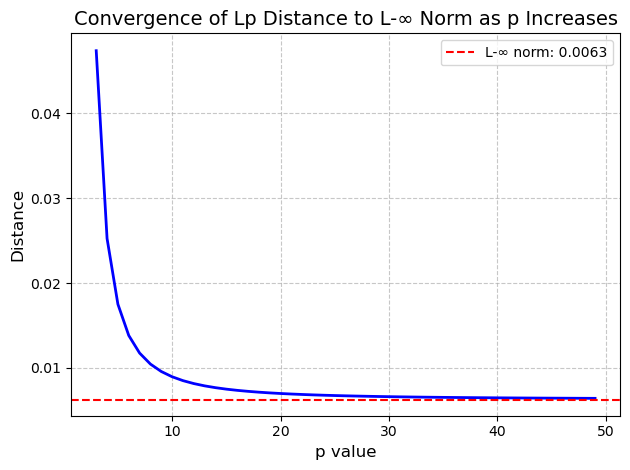

In [76]:
l_inf_norm = torch.max(torch.abs(x - x_adv_PGD)).item()
p_values = range(3,50)  
distances = [distance(x, x_adv_PGD, p).item() for p in p_values]

plt.plot(p_values, distances, 'b-', linewidth=2, markersize=6)
plt.axhline(y=l_inf_norm, color='r', linestyle='--', label=f'L-∞ norm: {l_inf_norm:.4f}')

plt.xlabel('p value', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Convergence of Lp Distance to L-∞ Norm as p Increases', fontsize=14)
plt.grid(True, ls="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()